## Confidence interval - Stochastic Volatility

In [1]:
USER_PATH <- "D:/Softwares/"
USER_PATH2 <- "D:/Softwares/GitHub/Discrete-SV-Models-Estimation/Code/" # Change only here
ILLUS_PATH <- paste0(USER_PATH2, "Illustration/")
DATA_INPUT_PATH <- paste0(USER_PATH,"GitHub/Systemic_Risk_Measures/Code/Python/Data_Extraction/")
FUNCTION_PATH <- paste0(USER_PATH, "GitHub/Systemic_Risk_Measures/Code/R/Functions/")

In [2]:
source(paste0(FUNCTION_PATH, "CoVaR_project2.R"))
source(paste0(FUNCTION_PATH, "CoVaR_Functions.R"))

In [3]:
library(ggplot2)
library(dplyr)
library(tidyquant)
library(stats)
library(tibble)
library(base)
library(tidyverse)
library(reshape2)
library(pbivnorm)
library(MASS)
library(stargazer)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'tidyquant' was built under R version 4.1.3"
Loading required package: lubridate


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: PerformanceAnalytics

Warning message:
"package 'PerformanceAnalytics' was built under R version 4.1.3"
Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked from 'package:dplyr':

    first, last



Attaching package: 'PerformanceAnalytics'


The following object is masked from 'package:graphics':

    legend


Loading required package: quantmod

Loadi

#### I) QML Method

In [4]:
sv_simul_can <- function(theta, log_h0){
    epsilon <- c()
    log_h <- c()
    omega <- theta[1]
    beta <- theta[2]
    sigma <- theta[3]
    eta <- rnorm(T, 0, 1)
    nu <- rnorm(T, 0, 1)
    
    log_h[1] <- omega + beta * log_h0 + sigma * nu[1]
    epsilon[1] <- sqrt(exp(log_h[1])) * eta[1]
    
    for (t in 2:T){
        log_h[t] <- omega + beta * log_h[t-1] + sigma * nu[t]
        epsilon[t] <- sqrt(exp(log_h[t])) * eta[t]
    }
    list(epsilon, log_h)
}

In [5]:
obj_sv <- function(theta, epsilon){
    alpha_t <- c()
    P_t <- c()
    F_t <- c()
    K_t <- c()
    omega <- theta[1]
    beta <- theta[2]
    sigma <- theta[3]
    mu_Z <- -1.270
    sigma_Z <- sqrt(pi**2/2)
    
    a0 <- 0
    beta0 <- 0.8
    P0 <- sigma**2
    F0 <- P0 + sigma_Z**2
    
    T <- length(epsilon)
    y_t <- log(epsilon**2)
    
    alpha_t[1] <- beta0 * a0 + omega
    P_t[1] <- beta**2 * P0 + sigma**2
    K_t[1] <- beta * P0 * 1/F0
    
    for (t in 2:T){
        F_t[t-1] <- P_t[t-1] + sigma_Z**2
        K_t[t] <- beta * P_t[t-1] * 1/F_t[t-1]
        alpha_t[t] <- beta * alpha_t[t-1] + K_t[t] *
            (y_t[t-1] - alpha_t[t-1] - mu_Z) + omega
        P_t[t] <- beta**2 * P_t[t-1] - K_t[t]**2 * F_t[t-1] + sigma**2
    }
    F_t[T] <- P_t[T-1] + sigma_Z**2
    qml <- -T/2 * log(2*pi) - 1/2*sum(log(F_t) +
        (log(epsilon**2) - alpha_t - mu_Z)**2 / F_t)
    -qml
}

In [6]:
estim_sv <- function(theta0, epsilon){
    valinit <- theta0
    lower <- c(-Inf, 0, 0)
    upper <- c(Inf, 0.999, Inf)
    res <- nlminb(valinit, obj_sv, lower=lower,
                  upper=upper, epsilon=epsilon)
    theta_hat <- res$par[1:3]
    theta_hat
}

In [7]:
# Inputs
# omega <- -0.736
# beta <- 0.9
# sigma <- 0.363

omega <- 0
beta <- 0.99
sigma <- 0.2
theta <- c(omega, beta, sigma)

# Estimation Inputs
omega0 <- -0.6
beta0 <- 0.9
sigma0 <- 0.5
theta0 <- c(omega0, beta0, sigma0)

log_h0 <- omega
T <- 2000

In [8]:
set.seed(123)
data <- sv_simul_can(theta, log_h0)
epsilon <- unlist(data[1])
log_h <- unlist(data[2])

In [9]:
estimation <- estim_sv(theta0, epsilon)
theta_hat <- estimation
theta_hat

[1] -0.004512162  0.985746469  0.242665709

In [10]:
alpha_t <- c()
P_t <- c()
F_t <- c()
K_t <- c()
omega <- theta_hat[1]
beta <- theta_hat[2]
sigma <- theta_hat[3]
mu_Z <- -1.270
sigma_Z <- sqrt(pi**2/2)
    
a0 <- 0
beta0 <- 0.8
P0 <- sigma**2
F0 <- P0 + sigma_Z**2
    
T <- length(epsilon)
y_t <- log(epsilon**2)
    
alpha_t[1] <- beta0 * a0 + omega
P_t[1] <- beta**2 * P0 + sigma**2
K_t[1] <- beta * P0 * 1/F0
    
for (t in 2:T){
    F_t[t-1] <- P_t[t-1] + sigma_Z**2
    K_t[t] <- beta * P_t[t-1] * 1/F_t[t-1]
    alpha_t[t] <- beta * alpha_t[t-1] + K_t[t] *
            (y_t[t-1] - alpha_t[t-1] - mu_Z) + omega
    P_t[t] <- beta**2 * P_t[t-1] - K_t[t]**2 * F_t[t-1] + sigma**2
}

In [11]:
# Input
n <- 500
selection <- 1:n

# Load Data
t<-1:n
col_names<-c('t', 'returns', 'volatility')
confidence_tab <- as.data.frame(epsilon[selection])
confidence_tab <- cbind(confidence_tab, sqrt(exp(log_h))[selection])
confidence_tab <- cbind(confidence_tab, sqrt(exp(alpha_t))[selection])
confidence_tab <- cbind(t, confidence_tab)
colnames(confidence_tab) <- col_names
confidence_tab <- melt(confidence_tab, id="t")

In [12]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
confidence_chart <-ggplot(data=confidence_tab, aes(x=t, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('black', 'red', 'blue'),
                       labels = c('Returns', 'Volatility', 'Estimated Volatility'))+
    labs(title = "Returns vs. Stochastic Volatility"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

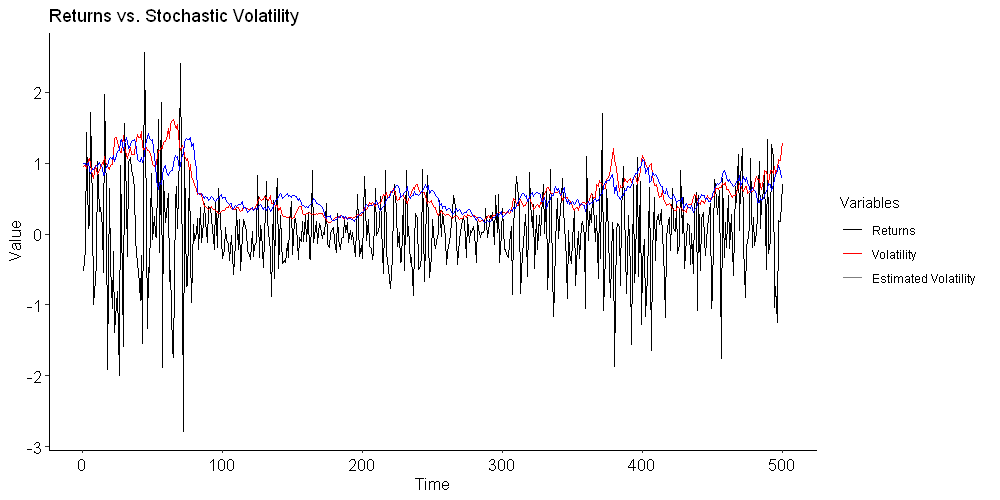

In [13]:
confidence_chart

In [36]:
sv_simul_can <- function(theta, log_h0, T){
    epsilon <- c()
    log_h <- c()
    omega <- theta[1]
    beta <- theta[2]
    sigma <- theta[3]
    eta <- rnorm(T, 0, 1)
    nu <- rnorm(T, 0, 1)
    
    log_h[1] <- omega + beta * log_h0 + sigma * nu[1]
    epsilon[1] <- sqrt(exp(log_h[1])) * eta[1]
    
    for (t in 2:T){
        log_h[t] <- omega + beta * log_h[t-1] + sigma * nu[t]
        epsilon[t] <- sqrt(exp(log_h[t])) * eta[t]
    }
    list(epsilon, log_h)
}

In [37]:
obj_sv <- function(theta, epsilon){
    alpha_t <- c()
    P_t <- c()
    F_t <- c()
    K_t <- c()
    omega <- theta[1]
    beta <- theta[2]
    sigma <- theta[3]
    mu_Z <- -1.270
    sigma_Z <- sqrt(pi**2/2)
    
    a0 <- 0
    beta0 <- 0.8
    P0 <- sigma**2
    F0 <- P0 + sigma_Z**2
    
    T <- length(epsilon)
    y_t <- log(epsilon**2)
    
    alpha_t[1] <- beta0 * a0 + omega
    P_t[1] <- beta**2 * P0 + sigma**2
    K_t[1] <- beta * P0 * 1/F0
    
    for (t in 2:T){
        F_t[t-1] <- P_t[t-1] + sigma_Z**2
        K_t[t] <- beta * P_t[t-1] * 1/F_t[t-1]
        alpha_t[t] <- beta * alpha_t[t-1] + K_t[t] *
            (y_t[t-1] - alpha_t[t-1] - mu_Z) + omega
        P_t[t] <- beta**2 * P_t[t-1] - K_t[t]**2 * F_t[t-1] + sigma**2
    }
    F_t[T] <- P_t[T-1] + sigma_Z**2
    qml <- -T/2 * log(2*pi) - 1/2*sum(log(F_t) +
        (log(epsilon**2) - alpha_t - mu_Z)**2 / F_t)
    -qml
}

In [38]:
estim_sv <- function(theta0, epsilon){
    valinit <- theta0
    lower <- c(-1, 0, 0)
    upper <- c(0, 0.999, Inf)
    res <- nlminb(valinit, obj_sv, lower=lower,
                  upper=upper, epsilon=epsilon)
    theta_hat <- res$par[1:3]
    theta_hat
}

In [39]:
# Inputs
omega <- -0.736
beta <- 0.9
sigma <- 0.363
theta <- c(omega, beta, sigma)

# Estimation Inputs
omega0 <- -0.6
beta0 <- 0.9
sigma0 <- 0.5
theta0 <- c(omega0, beta0, sigma0)

theta <- c(omega, beta, sigma)
log_h0 <- omega
T <- 3000
n <- 250
N <- T + n
M <- 1
S <- 41

alpha <- 0.05
alpha_l <- 0.025
alpha_h <- 0.0975

In [40]:
# Check algorithm running time
start.time <- Sys.time()

In [41]:
# Initialistation
sigma2_hat_conso <- matrix(0, nrow=M, ncol=N)
eta_hat_conso <- matrix(0, nrow=M, ncol=N)
nu_hat_conso <- matrix(0, nrow=M, ncol=N)
epsilon_conso <- matrix(0, nrow=M, ncol=N)
VaR_mat <- matrix(0, nrow=M, ncol=N)
VaR_true <- matrix(0, nrow=M, ncol=N)
xi_hat <- c()
xi_hat_boot <- c()
eta_boot <- c()
xi_boot <- c()
lower_bound <- matrix(0, nrow=M, ncol=N)
upper_bound <- matrix(0, nrow=M, ncol=N)
epsilon_boot <- c()
alpha_t_boot <- c()
alpha_t_boot_real <- c()

set.seed(123)

for (j in 1:M){
    epsilon <- c()
    log_h <- c()
    log_h_boot <- c()
    omega <- theta[1]
    beta <- theta[2]
    sigma <- theta[3]
    eta <- rnorm(N, 0, 1)
    nu <- rnorm(N, 0, 1)
    
    log_h[1] <- omega + beta * log_h0 + sigma * nu[1]
    epsilon[1] <- sqrt(exp(log_h[1])) * eta[1]
    
    for (t in 2:N){
        log_h[t] <- omega + beta * log_h[t-1] + sigma * nu[t]
        epsilon[t] <- sqrt(exp(log_h[t])) * eta[t]
    }
    
    epsilon <- (epsilon+0.0000001)
    epsilon_conso[j,] <- epsilon
    
    ## 1) Stochastic Volatility Model
    estimation <- estim_sv(theta0, epsilon)
    theta_hat <- estimation
    omega_hat <- theta_hat[1]
    beta_hat <- theta_hat[2]
    sigma_hat <- theta_hat[3]
    
    alpha_t <- c()
    P_t <- c()
    F_t <- c()
    K_t <- c()
    omega <- theta_hat[1]
    beta <- theta_hat[2]
    sigma <- theta_hat[3]
    mu_Z <- -1.270
    sigma_Z <- sqrt(pi**2/2)
    
    a0 <- 0
    beta0 <- 0.8
    P0 <- sigma**2
    F0 <- P0 + sigma_Z**2
    
    y_t <- log(epsilon**2)
    
    alpha_t[1] <- beta0 * a0 + omega
    P_t[1] <- beta**2 * P0 + sigma**2
    K_t[1] <- beta * P0 * 1/F0
    
    for (i in 2:N){
        F_t[i-1] <- P_t[i-1] + sigma_Z**2
        K_t[i] <- beta * P_t[i-1] * 1/F_t[i-1]
        alpha_t[i] <- beta * alpha_t[i-1] + K_t[i] *
                (y_t[i-1] - alpha_t[i-1] - mu_Z) + omega
        P_t[i] <- beta**2 * P_t[i-1] - K_t[i]**2 * F_t[i-1] + sigma**2
    }
    
    sigma2_hat_conso[j,] <- exp(alpha_t)
    eta_hat_conso[j,] <- epsilon / sqrt(exp(alpha_t))
    nu_hat_conso[j,] <- (alpha_t[1:N] - beta_hat * c(0, alpha_t[1:(N-1)]) - omega_hat) / sigma_hat
    
    xi_hat[j] <- quantile(eta_hat_conso[j,2:T], probs = seq(0, 1, 0.01))[alpha*100+1]
    VaR_mat[j,] <- xi_hat[j] * sqrt(sigma2_hat_conso[j,])
    
    eta_hat <- eta_hat_conso[j,]
    nu_hat <- nu_hat_conso[j,]
    
    # Confidence Interval - Bootstrap
    VaR_boot <- matrix(0, nrow=S, ncol=N)
    for (s in 1:S){
        index <- floor(runif(N, min=2, max=T+1))
        eta_boot <- (eta_hat[index] - mean(eta_hat[index]))/ sd(eta_hat[index])
        nu_boot <- nu_hat[index]
            
        log_h_boot[1] <- omega_hat + beta_hat * log_h0 + sigma_hat * nu_boot[1]
        epsilon_boot[1] <- sqrt(exp(log_h_boot[1])) * eta_boot[1]
    
        for (t in 2:N){
            log_h_boot[t] <- omega_hat + beta_hat * log_h_boot[t-1] + sigma_hat * nu_boot[t]
            epsilon_boot[t] <- sqrt(exp(log_h_boot[t])) * eta_boot[t]
        }
            
         ## 1) Stochastic Volatility Model
        estimation_boot <- estim_sv(theta0, epsilon_boot)
        theta_boot <- estimation_boot
        omega_boot <- theta_boot[1]
        beta_boot <- theta_boot[2]
        sigma_boot <- theta_boot[3]
            
        alpha_t_boot <- c()
        alpha_t_boot_real <- c()
        P_t_boot <- c()
        F_t_boot <- c()
        K_t_boot <- c()   
            
        P0_boot <- sigma_boot**2
        F0_boot <- P0_boot + sigma_Z**2    
        
        y_t_boot <- log(epsilon_boot**2)
            
        alpha_t_boot[1] <- beta0 * a0 + omega_boot
        alpha_t_boot_real[1] <- beta0 * a0 + omega_boot
        P_t_boot[1] <- beta_boot**2 * P0_boot + sigma_boot**2
        K_t_boot[1] <- beta_boot * P0_boot * 1/F0_boot
    
        for (k in 2:N){
            F_t_boot[k-1] <- P_t_boot[k-1] + sigma_Z**2
            K_t_boot[k] <- beta_boot * P_t_boot[k-1] * 1/F_t_boot[k-1]
            alpha_t_boot[k] <- beta_boot * alpha_t_boot[k-1] + K_t_boot[k] *
                    (y_t_boot[k-1] - alpha_t_boot[k-1] - mu_Z) + omega_boot
            alpha_t_boot_real[k] <- beta_boot * alpha_t_boot[k-1] + K_t_boot[k] *
                    (y_t[k-1] - alpha_t_boot[k-1] - mu_Z) + omega_boot
            P_t_boot[k] <- beta_boot**2 * P_t_boot[k-1] -
                K_t_boot[k]**2 * F_t_boot[k-1] + sigma_boot**2
        }    
            
        sigma2_hat_boot_real <- exp(alpha_t_boot_real)
        sigma2_hat_boot <- exp(alpha_t_boot)
        eta_hat_boot <- epsilon_boot / sqrt(exp(alpha_t_boot))   
        
        xi_hat_boot[s] <- quantile(eta_hat_boot[2:T], probs = seq(0, 1, 0.01))[alpha*100+1]
    
        VaR_boot[s,] <- xi_hat_boot[s] * sqrt(sigma2_hat_boot_real)
        # VaR_boot[s,] <- xi_hat_boot[s] * sqrt(sigma2_hat_conso[j,])
    }
    for (l in 1:N){
        lower_bound[j,l] <- quantile(VaR_boot[,l], probs = seq(0, 1, 0.001))[alpha_l*1000+1]
        upper_bound[j,l] <- quantile(VaR_boot[,l], probs = seq(0, 1, 0.001))[alpha_h*1000+1]
    }
}

In [42]:
end.time <- Sys.time()
time.taken<-round(end.time-start.time,2)
time.taken

Time difference of 28.45 secs

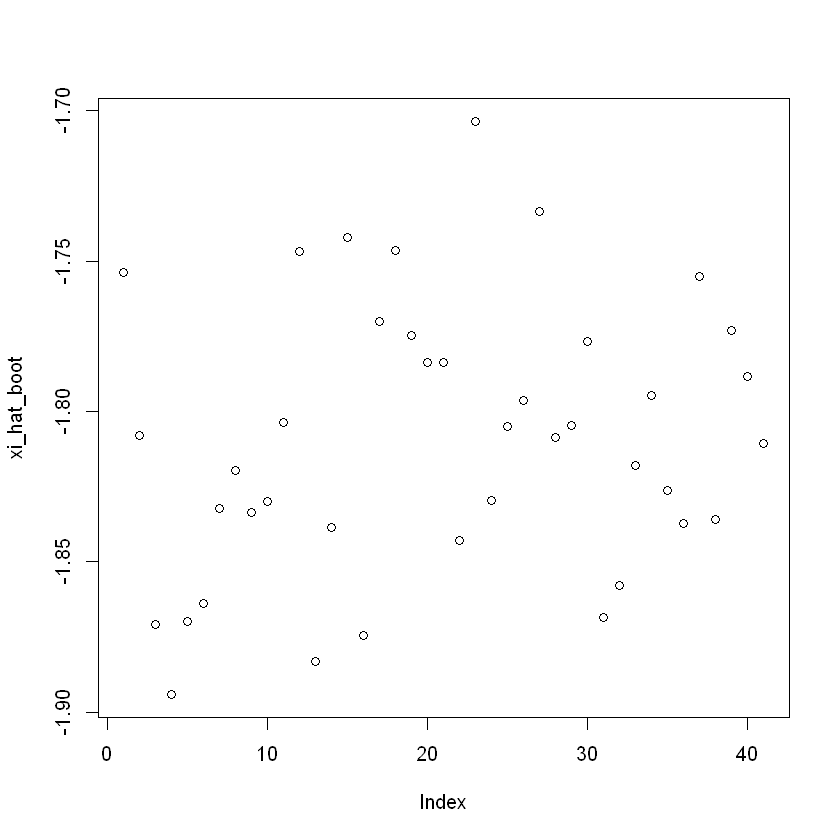

In [43]:
plot(xi_hat_boot)

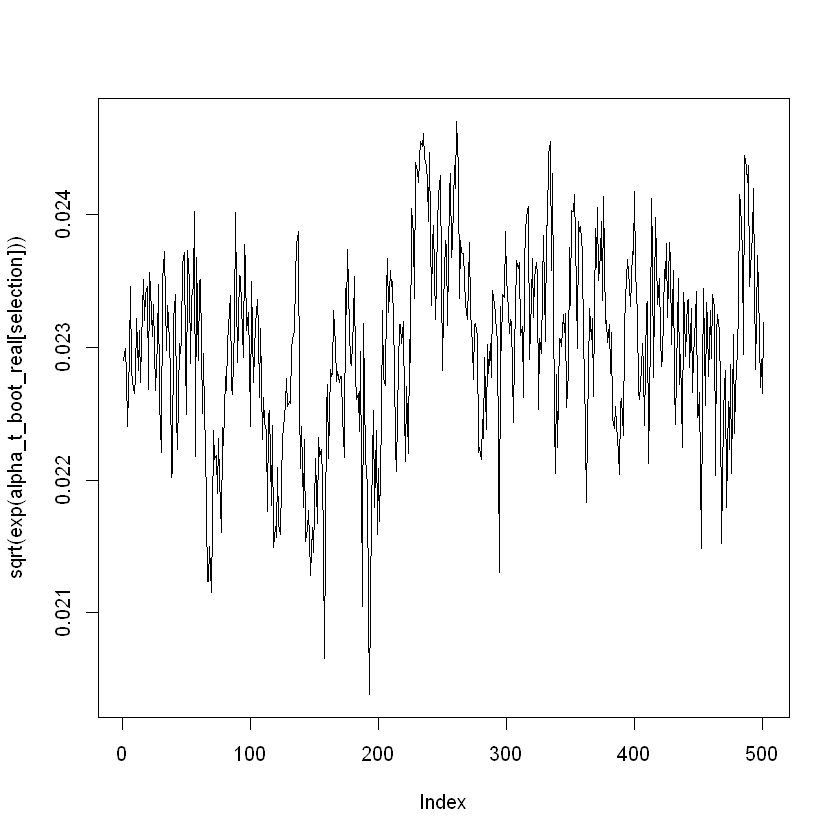

In [49]:
plot(sqrt(exp(alpha_t_boot_real[selection])), type='l')

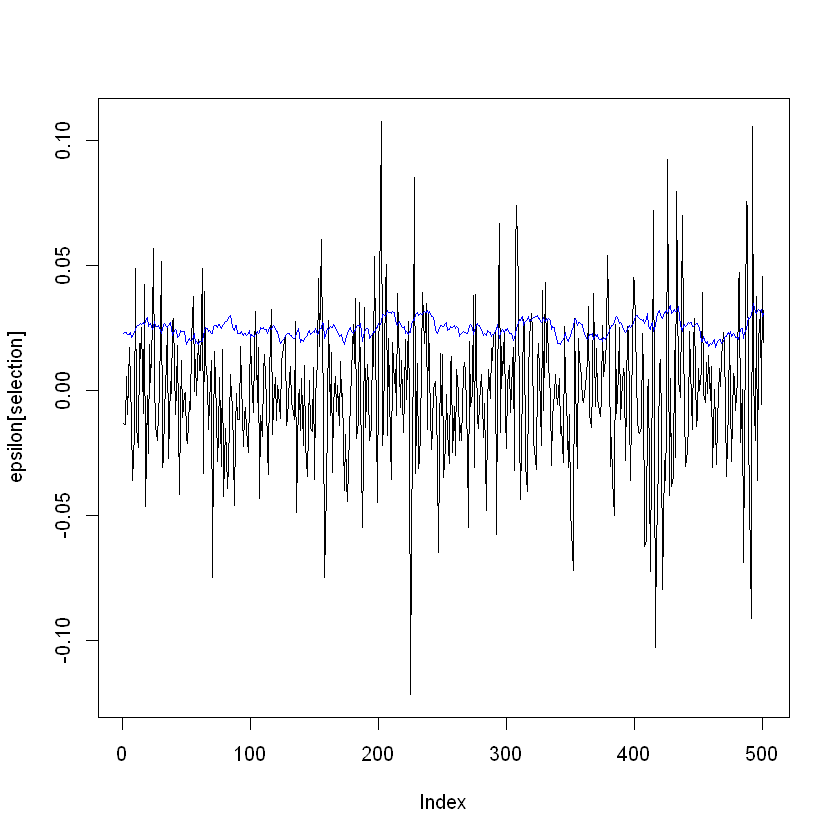

In [53]:
plot(epsilon[selection], type='l')
lines(sqrt(sigma2_hat_conso[1,selection]), type='l', col='blue')

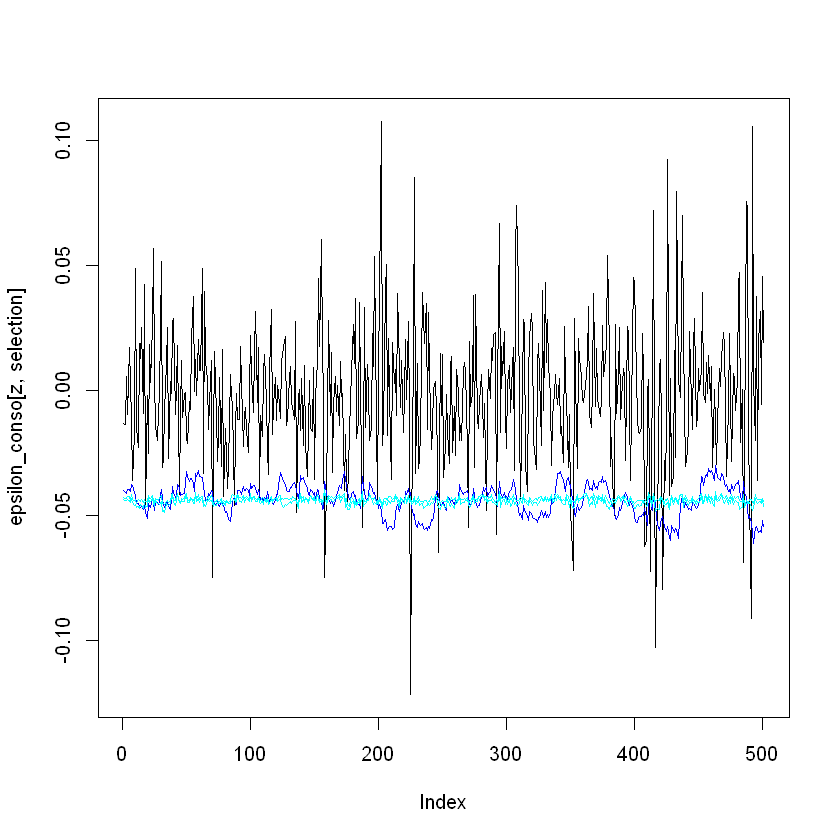

In [44]:
z <- 1
selection <- 2000:2500
plot(epsilon_conso[z,selection], type='l', col='black')
lines(VaR_mat[z,selection], type='l', col='blue')
lines(lower_bound[z,selection], type='l', col='cyan')
lines(upper_bound[z,selection], type='l', col='cyan')

In [31]:
lower_bound[z,selection]
upper_bound[z,selection]

[1] -0.04308351 -0.04362739 -0.04412416 -0.04244849 -0.04233763 -0.04359876
  [7] -0.04029780 -0.04091823 -0.04401500 -0.04506828 -0.04863531 -0.04872823
 [13] -0.04991005 -0.05043471 -0.04989502 -0.05121235 -0.04957055 -0.05237240
 [19] -0.05517867 -0.04853941 -0.05000314 -0.05047726 -0.04624922 -0.04802028
 [25] -0.05176308 -0.04815406 -0.04817763 -0.04908570 -0.04772648 -0.04272264
 [31] -0.04658606 -0.04880276 -0.05043587 -0.04856185 -0.04782177 -0.04940788
 [37] -0.05097676 -0.04697567 -0.04135799 -0.04378498 -0.04611517 -0.04539459
 [43] -0.04023475 -0.04182303 -0.04520307 -0.04447414 -0.04457734 -0.04439074
 [49] -0.03965990 -0.03460833 -0.03684950 -0.03912193 -0.03778112 -0.03777963
 [55] -0.03992620 -0.04320665 -0.03544050 -0.03678278 -0.03444964 -0.03682140
 [61] -0.03713854 -0.03733311 -0.04135401 -0.04423166 -0.04732907 -0.04698620
 [67] -0.04432582 -0.04508186 -0.04288182 -0.04321676 -0.04798649 -0.04873066
 [73] -0.04892863 -0.04768064 -0.04957848 -0.05000082 -0.04715894 -0.04927288
 [79] -0.04954110 -0.05233794 -0.05196555 -0.05312537 -0.05533837 -0.05650653
 [85] -0.05288748 -0.04774053 -0.04547686 -0.04883506 -0.04890218 -0.04294269
 [91] -0.04315557 -0.04332958 -0.04450133 -0.04122095 -0.04316682 -0.04293830
 [97] -0.04190161 -0.04301701 -0.04505692 -0.03990132 -0.04198044 -0.04090898
[103] -0.04085102 -0.04207925 -0.04479396 -0.04270649 -0.04390388 -0.04722331
[109] -0.04651644 -0.04742723 -0.04580318 -0.04619308 -0.04333708 -0.04525970
[115] -0.04783804 -0.04621499 -0.04862390 -0.04915052 -0.04681794 -0.04456454
[121] -0.04463467 -0.04067390 -0.03540464 -0.03647480 -0.03765342 -0.03888384
[127] -0.04055879 -0.04251187 -0.04320774 -0.04340491 -0.04170661 -0.04166785
[133] -0.04030881 -0.03953985 -0.04021470 -0.04275525 -0.04646859 -0.04255409
[139] -0.03646359 -0.03816775 -0.03719138 -0.03949772 -0.03984623 -0.04189599
[145] -0.04480423 -0.04526291 -0.04266683 -0.04356778 -0.04452419 -0.04397169
[151] -0.04679117 -0.04254465 -0.04282403 -0.04633299 -0.04715341 -0.05113463
[157] -0.05078898 -0.03891861 -0.04386246 -0.04697841 -0.04641303 -0.04839728
[163] -0.04747241 -0.04776019 -0.05003395 -0.04736728 -0.04524302 -0.04439400
[169] -0.04064497 -0.04158373 -0.04205024 -0.03880613 -0.03465313 -0.03838709
[175] -0.04009099 -0.04330227 -0.04673167 -0.04734429 -0.04426403 -0.04333347
[181] -0.04549516 -0.04518889 -0.04800568 -0.04884644 -0.04845798 -0.05086633
[187] -0.03692266 -0.04122074 -0.04351709 -0.04622464 -0.04663778 -0.04612151
[193] -0.03938716 -0.04129783 -0.04232555 -0.04424052 -0.04385940 -0.04774974
[199] -0.04750463 -0.05063446 -0.04906561 -0.05164052 -0.05703151 -0.05703004
[205] -0.05559465 -0.05764187 -0.06017069 -0.05907968 -0.05862337 -0.05830144
[211] -0.05964292 -0.05882062 -0.05256198 -0.05047997 -0.04918693 -0.05178330
[217] -0.05033872 -0.04802794 -0.04762540 -0.04816736 -0.04331538 -0.04483903
[223] -0.04209064 -0.04446712 -0.04394606 -0.04997187 -0.05363237 -0.05314637
[229] -0.05772317 -0.05890660 -0.05643791 -0.05760412 -0.05821330 -0.05726984
[235] -0.05906272 -0.05968527 -0.05884222 -0.06004495 -0.05850373 -0.05941876
[241] -0.05555621 -0.05598189 -0.05504802 -0.04651798 -0.04350743 -0.04276992
[247] -0.04507005 -0.04936357 -0.04934040 -0.04821734 -0.04829357 -0.05066215
[253] -0.05154607 -0.04545405 -0.04620751 -0.04832610 -0.04735773 -0.04735295
[259] -0.04892917 -0.04677635 -0.04851760 -0.04716033 -0.04051529 -0.04229606
[265] -0.04303874 -0.04455660 -0.04365006 -0.04375490 -0.04304759 -0.04492731
[271] -0.04878527 -0.04955848 -0.04729381 -0.04216397 -0.04529708 -0.04763622
[277] -0.05035986 -0.04939957 -0.04943277 -0.04617883 -0.04451129 -0.04182323
[283] -0.04331692 -0.04162706 -0.04537278 -0.04421868 -0.04351722 -0.04062762
[289] -0.04199154 -0.04242645 -0.04426200 -0.04601465 -0.04994615 -0.03909227
[295] -0.04375458 -0.04478456 -0.04577412 -0.04401968 -0.04582447 -0.04536028
[301] -0.04698592 -0.04332848 -0.04314094 -0.04269587 -0.03804539 -0.03975647
[307] -0.04266495 -0.046

[1] -0.04278141 -0.04332148 -0.04381476 -0.04215085 -0.04204076 -0.04329305
  [7] -0.04001524 -0.04063131 -0.04370637 -0.04475226 -0.04829429 -0.04838655
 [13] -0.04956008 -0.05008107 -0.04954517 -0.05085325 -0.04922297 -0.05200517
 [19] -0.05479176 -0.04819906 -0.04965252 -0.05012332 -0.04592493 -0.04768356
 [25] -0.05140013 -0.04781640 -0.04783981 -0.04874152 -0.04739183 -0.04242307
 [31] -0.04625940 -0.04846056 -0.05008222 -0.04822134 -0.04748645 -0.04906143
 [37] -0.05061932 -0.04664628 -0.04106799 -0.04347796 -0.04579182 -0.04507629
 [43] -0.03995263 -0.04152977 -0.04488611 -0.04416229 -0.04426476 -0.04407947
 [49] -0.03938181 -0.03436566 -0.03659111 -0.03884761 -0.03751620 -0.03751472
 [55] -0.03964624 -0.04290369 -0.03519200 -0.03652486 -0.03420808 -0.03656321
 [61] -0.03687813 -0.03707134 -0.04106404 -0.04392151 -0.04699720 -0.04665674
 [67] -0.04401501 -0.04476575 -0.04258113 -0.04291373 -0.04765001 -0.04838896
 [73] -0.04858555 -0.04734631 -0.04923085 -0.04965022 -0.04682826 -0.04892739
 [79] -0.04919372 -0.05197095 -0.05160117 -0.05275286 -0.05495034 -0.05611031
 [85] -0.05251664 -0.04740578 -0.04515798 -0.04849263 -0.04855928 -0.04264158
 [91] -0.04285296 -0.04302575 -0.04418929 -0.04093191 -0.04286414 -0.04263722
 [97] -0.04160780 -0.04271537 -0.04474098 -0.03962153 -0.04168607 -0.04062213
[103] -0.04056458 -0.04178420 -0.04447987 -0.04240703 -0.04359603 -0.04689219
[109] -0.04619027 -0.04709468 -0.04548201 -0.04586918 -0.04303320 -0.04494235
[115] -0.04750261 -0.04589093 -0.04828296 -0.04880588 -0.04648966 -0.04425206
[121] -0.04432169 -0.04038869 -0.03515639 -0.03621904 -0.03738940 -0.03861119
[127] -0.04027440 -0.04221378 -0.04290478 -0.04310056 -0.04141417 -0.04137568
[133] -0.04002617 -0.03926260 -0.03993272 -0.04245545 -0.04614275 -0.04225571
[139] -0.03620791 -0.03790012 -0.03693059 -0.03922077 -0.03956683 -0.04160222
[145] -0.04449007 -0.04494553 -0.04236765 -0.04326229 -0.04421199 -0.04366337
[151] -0.04646308 -0.04224633 -0.04252375 -0.04600811 -0.04682277 -0.05077608
[157] -0.05043285 -0.03864572 -0.04355490 -0.04664900 -0.04608759 -0.04805792
[163] -0.04713954 -0.04742530 -0.04968312 -0.04703515 -0.04492578 -0.04408272
[169] -0.04035998 -0.04129215 -0.04175539 -0.03853402 -0.03441015 -0.03811793
[175] -0.03980988 -0.04299864 -0.04640399 -0.04701232 -0.04395365 -0.04302962
[181] -0.04517615 -0.04487203 -0.04766907 -0.04850393 -0.04811819 -0.05050966
[187] -0.03666377 -0.04093170 -0.04321196 -0.04590052 -0.04631076 -0.04579811
[193] -0.03911098 -0.04100825 -0.04202877 -0.04393031 -0.04355187 -0.04741492
[199] -0.04717154 -0.05027941 -0.04872157 -0.05127842 -0.05663162 -0.05663015
[205] -0.05520483 -0.05723769 -0.05974878 -0.05866542 -0.05821231 -0.05789264
[211] -0.05922471 -0.05840818 -0.05219342 -0.05012601 -0.04884204 -0.05142020
[217] -0.04998575 -0.04769117 -0.04729146 -0.04782961 -0.04301166 -0.04452462
[223] -0.04179551 -0.04415532 -0.04363791 -0.04962148 -0.05325630 -0.05277371
[229] -0.05731842 -0.05849356 -0.05604217 -0.05720020 -0.05780511 -0.05686827
[235] -0.05864858 -0.05926677 -0.05842962 -0.05962392 -0.05809351 -0.05900212
[241] -0.05516665 -0.05558935 -0.05466203 -0.04619180 -0.04320236 -0.04247002
[247] -0.04475402 -0.04901744 -0.04899443 -0.04787924 -0.04795494 -0.05030691
[253] -0.05118463 -0.04513533 -0.04588351 -0.04798724 -0.04702566 -0.04702091
[259] -0.04858609 -0.04644836 -0.04817740 -0.04682965 -0.04023120 -0.04199949
[265] -0.04273695 -0.04424417 -0.04334399 -0.04344809 -0.04274574 -0.04461229
[271] -0.04844319 -0.04921098 -0.04696219 -0.04186832 -0.04497946 -0.04730220
[277] -0.05000674 -0.04905319 -0.04908615 -0.04585503 -0.04419918 -0.04152997
[283] -0.04301318 -0.04133517 -0.04505463 -0.04390862 -0.04321208 -0.04034274
[289] -0.04169710 -0.04212896 -0.04395164 -0.04569200 -0.04959594 -0.03881816
[295] -0.04344778 -0.04447054 -0.04545316 -0.04371102 -0.04550316 -0.04504222
[301] -0.04665646 -0.04302466 -0.04283844 -0.04239649 -0.03777862 -0.03947770
[307] -0.04236579 -0.046

In [30]:
mean(eta_boot)
sd(eta_boot)

[1] -2.224669e-17

[1] 1

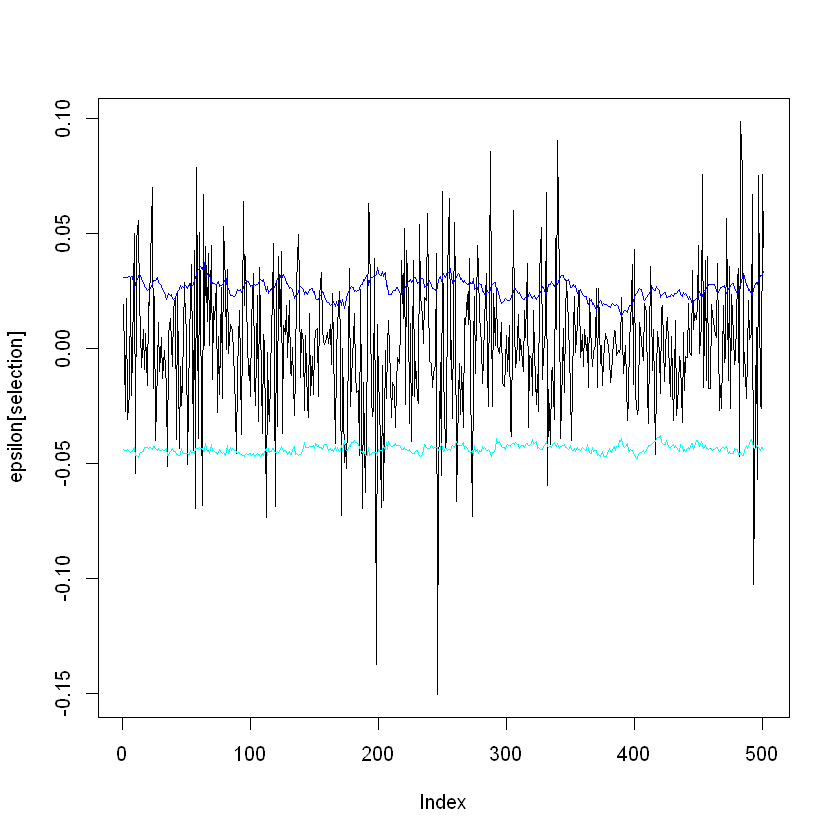

In [80]:
selection <- 2500:3000
plot(epsilon[selection], type='l')
lines(sqrt(sigma2_hat_conso[1,selection]), type='l', col='blue')
lines(-1.7*sqrt(sigma2_hat_boot_real[selection]), type='l', col='cyan')

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""tye" is not a graphical parameter"


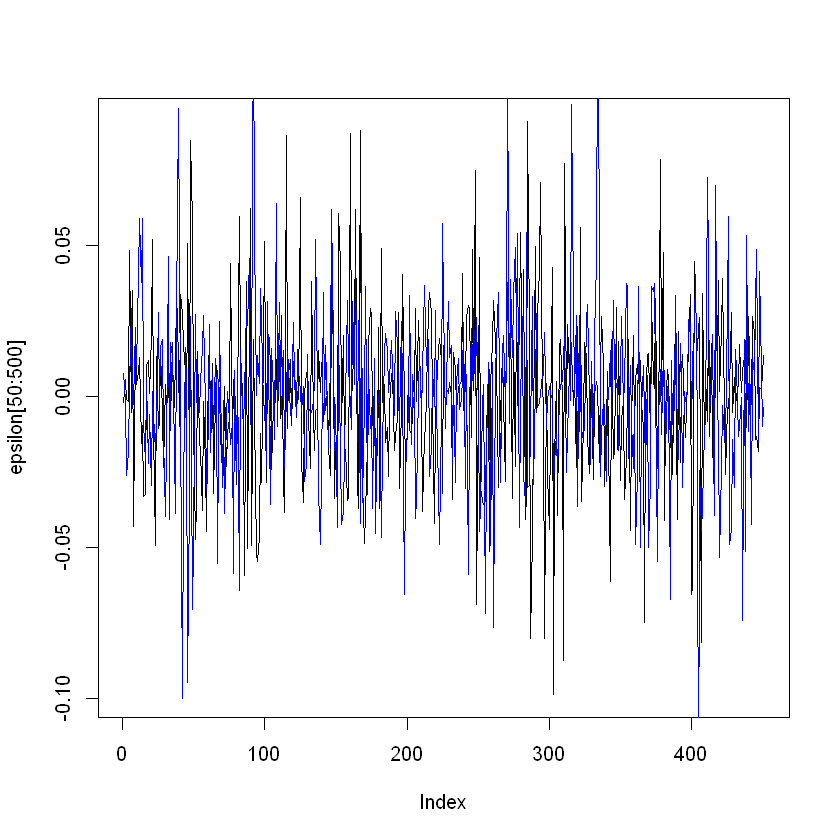

In [53]:
plot(epsilon[50:500], type='l', col='black')
lines(epsilon_boot[50:500], tye='l', col='blue')

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""tye" is not a graphical parameter"
Warning message in plot.window(...):
""tye" is not a graphical parameter"
Warning message in plot.xy(xy, type, ...):
""tye" is not a graphical parameter"
Warning message in axis(side = side, at = at, labels = labels, ...):
""tye" is not a graphical parameter"
Warning message in axis(side = side, at = at, labels = labels, ...):
""tye" is not a graphical parameter"
Warning message in box(...):
""tye" is not a graphical parameter"
Warning message in title(...):
""tye" is not a graphical parameter"


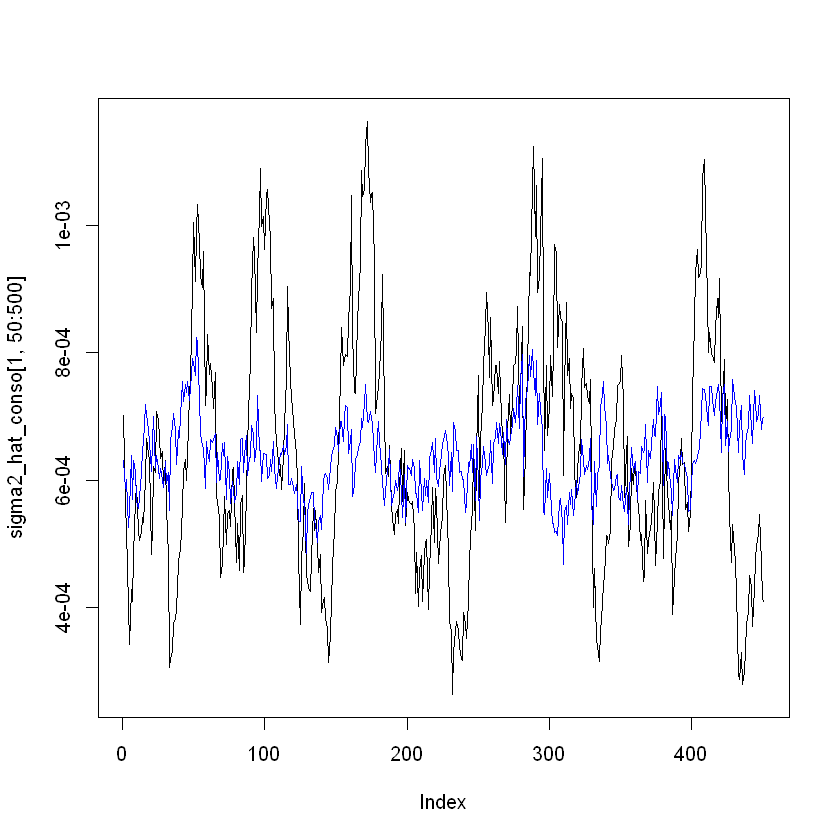

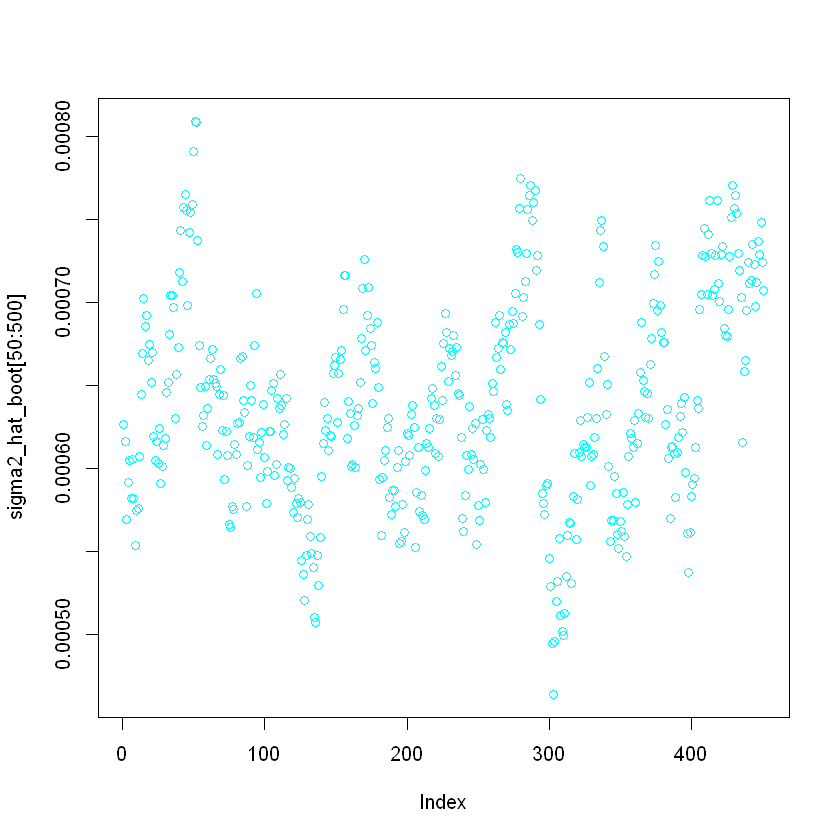

In [62]:
plot(sigma2_hat_conso[1,50:500], type='l', col='black')
lines(sigma2_hat_boot_real[50:500], tye='l', col='blue')
plot(sigma2_hat_boot[50:500], tye='l', col='cyan')

In [ ]:
count <- c()
for (t in 1:N){
    if ()
}

In [ ]:
# stocks <- stocks[,5]
stocks <- system

In [ ]:
selection <- 2500:3000
epsilon <- stocks[stocks!=0] * 100
epsilon <- epsilon[selection]
DATE <- as.Date(returns[selection,1])
DATE_VIX <- as.Date(date_vix)
T <- length(epsilon)

In [ ]:
plot(epsilon, type='l')

In [ ]:
plot(vix_dat, type='l')


In [ ]:
# Estimation Inputs
omega0 <- -0.6
beta0 <- 0.9
sigma0 <- 0.5
theta0 <- c(omega0, beta0, sigma0)

### A/ Stochastic Volatility Model

In [ ]:
estimation <- estim_sv(theta0, epsilon)
theta_hat <- estimation
theta_hat

In [ ]:
alpha_t <- c()
P_t <- c()
F_t <- c()
K_t <- c()
omega <- theta_hat[1]
beta <- theta_hat[2]
sigma <- theta_hat[3]
mu_Z <- -1.270
sigma_Z <- sqrt(pi**2/2)
    
a0 <- 0
beta0 <- 0.8
P0 <- sigma**2
F0 <- P0 + sigma_Z**2
    
T <- length(epsilon)
y_t <- log(epsilon**2)
    
alpha_t[1] <- beta0 * a0 + omega
P_t[1] <- beta**2 * P0 + sigma**2
K_t[1] <- beta * P0 * 1/F0
    
for (t in 2:T){
    F_t[t-1] <- P_t[t-1] + sigma_Z**2
    K_t[t] <- beta * P_t[t-1] * 1/F_t[t-1]
    alpha_t[t] <- beta * alpha_t[t-1] + K_t[t] *
            (y_t[t-1] - alpha_t[t-1] - mu_Z) + omega
    P_t[t] <- beta**2 * P_t[t-1] - K_t[t]**2 * F_t[t-1] + sigma**2
}

## GARCH Model

In [ ]:
omega_0 <- -0.6
alpha_0 <- 0.1
beta_0 <- 0.85

In [ ]:
# Initialisation
sigma2_hat <- c()
eta_hat <- c()

estimation <- estimgarch11(omega_0, alpha_0, beta_0, epsilon)
theta_hat_g <- estimation$coef

omega_hat_g <- theta_hat_g[1]
alpha_hat_g <- theta_hat_g[2]
beta_hat_g <- theta_hat_g[3]

sigma2_hat[1]<-omega_hat_g
eta_hat[1] <- epsilon[1] / sqrt(sigma2_hat[1])
for (i in 2:T){
    sigma2_hat[i]<-omega_hat_g + alpha_hat_g * epsilon[i-1]**2 + beta_hat_g * sigma2_hat[i-1]
    eta_hat[i] <- epsilon[i] / sqrt(sigma2_hat[i])
}

In [ ]:
# Load Data
t<-1:T
col_names<-c('t', 'returns', 'stochastic volatility', 'garch volatility')
confidence_tab <- as.data.frame(epsilon)
confidence_tab <- cbind(confidence_tab, sqrt(exp(alpha_t)))
confidence_tab <- cbind(confidence_tab, sqrt(sigma2_hat))
confidence_tab <- cbind(t, confidence_tab)
colnames(confidence_tab) <- col_names
confidence_tab <- melt(confidence_tab, id="t")
confidence_tab <- cbind(rep(DATE[1:T]), confidence_tab)
colnames(confidence_tab) <- c('Date', 't', 'variable', 'value')

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
confidence_chart <-ggplot(data=confidence_tab, aes(x=Date, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('black', 'blue', 'red'),
                       labels = c('Returns', 'Stochastic Volatility', 'Garch Volatility'))+
    labs(title = "S&P 500 Returns vs. Stochastic & GARCH Volatility"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

In [ ]:
confidence_chart

In [ ]:
# pdf(file=paste0(ILLUS_PATH, "QML_volat_RD.pdf"),width=10, height=5)
# confidence_chart
# dev.off()

In [ ]:
vix_100 <- vix_dat[1:501] / mean(vix_dat[1:501]) * 100
garch_100 <- sqrt(sigma2_hat) / mean(sqrt(sigma2_hat)) * 100

In [ ]:
length(vix_100)

In [ ]:
# Load Data
t<-1:T
col_names<-c('t', 'vix', 'garch volatility')
confidence_tab_vix <- as.data.frame(vix_100)
confidence_tab_vix <- cbind(confidence_tab_vix, garch_100)
confidence_tab_vix <- cbind(t, confidence_tab_vix)
colnames(confidence_tab_vix) <- col_names
confidence_tab_vix <- melt(confidence_tab_vix, id="t")
confidence_tab_vix <- cbind(rep(DATE[1:T]), confidence_tab_vix)
colnames(confidence_tab_vix) <- c('Date', 't', 'variable', 'value')

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
confidence_chart_vix <-ggplot(data=confidence_tab_vix, aes(x=Date, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('blue', 'red'),
                       labels = c('Vix', 'GARCH Volatility'))+
    labs(title = "S&P 500 Returns vs. VIX"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

In [ ]:
confidence_chart_vix

#### Spread

In [ ]:
# Load Data
t<-1:T
col_names<-c('t', 'volatility risk premium', 'zero line')
confidence_tab_spread <- as.data.frame(vix_100 - garch_100)
confidence_tab_spread <- cbind(confidence_tab_spread, rep(0, 501))
confidence_tab_spread <- cbind(t, confidence_tab_spread)
colnames(confidence_tab_spread) <- col_names
confidence_tab_spread <- melt(confidence_tab_spread, id="t")
confidence_tab_spread <- cbind(rep(DATE[1:T]), confidence_tab_spread)
colnames(confidence_tab_spread) <- c('Date', 't', 'variable', 'value')

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
confidence_chart_spread <-ggplot(data=confidence_tab_spread, aes(x=Date, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('black', 'red'),
                       labels = c('Volatility Risk Premium', 'Zero Line'))+
    labs(title = "Volatility Risk Premium"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

In [ ]:
confidence_chart_spread

#### Risk

#### A/ Stochastic Volatility

In [ ]:
alpha1 <- 0.20
eta_hat <- epsilon / sqrt(exp(alpha_t))
xi_hat <- quantile(eta_hat, probs = seq(0, 1, 0.01))[alpha1*100+1]
VaR_SV <- sqrt(exp(alpha_t)) * xi_hat

#### B/ GARCH

In [ ]:
eta_hat_g <- epsilon / sqrt(sigma2_hat)
xi_hat_g <- quantile(eta_hat_g, probs = seq(0, 1, 0.01))[alpha1*100+1]
VaR_G <- sqrt(sigma2_hat) * xi_hat_g

#### C/ UNCONDITIONAL

In [ ]:
VaR_U <- quantile(epsilon, probs = seq(0, 1, 0.01))[alpha1*100+1]

In [ ]:
col_names<-c('t', 'returns', 'VaR_SV', 'VaR_G', 'VaR_U')
confidence_tab_var <- as.data.frame(epsilon)
confidence_tab_var <- cbind(confidence_tab_var, VaR_SV)
confidence_tab_var <- cbind(confidence_tab_var, VaR_G)
confidence_tab_var <- cbind(confidence_tab_var, VaR_U)
confidence_tab_var <- cbind(t, confidence_tab_var)
colnames(confidence_tab_var) <- col_names
confidence_tab_var <- melt(confidence_tab_var, id="t")
confidence_tab_var <- cbind(rep(DATE[1:T]), confidence_tab_var)
colnames(confidence_tab_var) <- c('Date', 't', 'variable', 'value')

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
confidence_chart_var <-ggplot(data=confidence_tab_var, aes(x=Date, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('black', 'red', 'blue', 'cyan'),
                       labels = c('Returns', '-VaR SV', '-VaR Garch', '-Unconditional VaR'))+
    labs(title = "Returns vs. VaR"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

In [ ]:
confidence_chart_var

In [ ]:
pdf(file=paste0(ILLUS_PATH, "VaR_RD_020.pdf"),width=10, height=5)
confidence_chart_var
dev.off()

### Expected Shortfall

In [ ]:
ES_g <- c()
id_g <- c()
ES_sv <- c()
id_sv <- c()

ES_u <- rep(quantile(epsilon, probs = seq(0, 1, 0.01))[alpha1*100+1], 500)

for (t in 1:T){
    if (eta_hat_g[t] < xi_hat_g){
        id_g[t] <- 1
    } else {
        id_g[t] <- 0
    }
}   
eta_hat_g_mod <- id_g * eta_hat_g
eta_hat_g_mod <- eta_hat_g_mod[eta_hat_g_mod!=0]

ES_g <- mean(eta_hat_g_mod) * sqrt(exp(alpha_t))

for (t in 1:T){
    if (eta_hat[t] < xi_hat){
        id_sv[t] <- 1
    } else {
        id_sv[t] <- 0
    }
}   

eta_hat_sv_mod <- id_sv * eta_hat
eta_hat_sv_mod <- eta_hat_sv_mod[eta_hat_sv_mod!=0]

ES_sv <- mean(eta_hat_sv_mod) * sqrt(sigma2_hat)

In [ ]:
plot(epsilon, type='l', col='black')
lines(ES_sv, type='l', col='blue')
lines(ES_g, type='l', col='red')
lines(ES_u, type='l', col='cyan')

In [ ]:
# Load Data
t<-1:T
col_names<-c('t', 'Log-Returns', 'ES Stochastic Volatility', 'ES GARCH', 'ES Unconditional')
es_tab <- as.data.frame(epsilon[1:T])
es_tab <- cbind(es_tab, ES_sv[1:T])
es_tab <- cbind(es_tab, ES_g[1:T])
es_tab <- cbind(es_tab, ES_u[1:T])
es_tab <- cbind(t, es_tab)
colnames(es_tab) <- col_names
es_tab <- melt(es_tab, id="t")
es_tab <- cbind(rep(DATE[1:T]), es_tab)
colnames(es_tab) <- c('Date', 't', 'variable', 'value')

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
es_chart <-ggplot(data=es_tab, aes(x=Date, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('black', 'red', 'blue', 'cyan'),
                       labels = c('Returns', 'Expected Shortfall SV',
                                  'Expected  Shortfall Garch',
                                  'Expected Shortfall VaR'))+
    labs(title = "Returns vs. Expected Shortfall"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

In [ ]:
es_chart

In [ ]:
pdf(file=paste0(ILLUS_PATH, "ES_RD_020.pdf"),width=10, height=5)
es_chart
dev.off()

### Monte Carlo - on Real Data

In [ ]:
T <- 3000
n <- 250
N <- T+n
M <- length(returns[1,]) - 1
epsilon_conso <- returns[,2:(M+1)]

In [ ]:
# Initialistation
sigma2_hat_g <- matrix(0, nrow=M, ncol=N)
eta_hat_g <- matrix(0, nrow=M, ncol=N)
VaR_mat_g <- matrix(0, nrow=M, ncol=N)
xi_hat_g <- c()
    
sigma2_hat_sv <- matrix(0, nrow=M, ncol=N)
eta_hat_sv <- matrix(0, nrow=M, ncol=N)
VaR_mat_sv <- matrix(0, nrow=M, ncol=N)
xi_hat_sv <- c()

VaR_mat_u <- matrix(0, nrow=M, ncol=N)

for (j in 1:M){
    epsilon <- epsilon_conso[,j]
    epsilon <- (epsilon+0.00001) * 100
    
    ## 1) Stochastic Volatility Model
    estimation <- estim_sv(theta0, epsilon)
    theta_hat <- estimation
    theta_hat
    
    alpha_t <- c()
    P_t <- c()
    F_t <- c()
    K_t <- c()
    omega <- theta_hat[1]
    beta <- theta_hat[2]
    sigma <- theta_hat[3]
    mu_Z <- -1.270
    sigma_Z <- sqrt(pi**2/2)
    
    a0 <- 0
    beta0 <- 0.8
    P0 <- sigma**2
    F0 <- P0 + sigma_Z**2
    
    y_t <- log(epsilon**2)
    
    alpha_t[1] <- beta0 * a0 + omega
    P_t[1] <- beta**2 * P0 + sigma**2
    K_t[1] <- beta * P0 * 1/F0
    
    for (i in 2:N){
        F_t[i-1] <- P_t[i-1] + sigma_Z**2
        K_t[i] <- beta * P_t[i-1] * 1/F_t[i-1]
        alpha_t[i] <- beta * alpha_t[i-1] + K_t[i] *
                (y_t[i-1] - alpha_t[i-1] - mu_Z) + omega
        P_t[i] <- beta**2 * P_t[i-1] - K_t[i]**2 * F_t[i-1] + sigma**2
    }
    
    sigma2_hat_sv[j,] <- exp(alpha_t)
    eta_hat_sv[j,] <- epsilon / sqrt(exp(alpha_t))
    xi_hat_sv[j] <- quantile(eta_hat_sv[j,1:T], probs = seq(0, 1, 0.01))[alpha1*100+1]
    VaR_mat_sv[j,] <- xi_hat_sv[j] * sqrt(sigma2_hat_sv[j,])
    
    ## 2) GARCH
    estimation_g <- estimgarch11(omega_0, alpha_0, beta_0, epsilon)
    theta_hat_g <- estimation_g$coef

    omega_hat_g <- theta_hat_g[1]
    alpha_hat_g <- theta_hat_g[2]
    beta_hat_g <- theta_hat_g[3]

    sigma2_hat_g[j,1]<-omega_hat_g
    eta_hat_g[j,1] <- epsilon[1] / sqrt(sigma2_hat_g[j,1])
    for (i in 2:N){
        sigma2_hat_g[j,i]<-omega_hat_g + alpha_hat_g * epsilon[i-1]**2 +
            beta_hat_g * sigma2_hat_g[j,i-1]
        eta_hat_g[j,i] <- epsilon[i] / sqrt(sigma2_hat_g[j,i])
    }
    xi_hat_g[j] <- quantile(eta_hat_g[j,1:T], probs = seq(0, 1, 0.01))[alpha1*100+1]
    VaR_mat_g[j,] <- xi_hat_g[j] * sqrt(sigma2_hat_g[j,])
    
    ## 3) unconditional Model
    VaR_mat_u[j,] <- quantile(epsilon[1:T], probs = seq(0, 1, 0.01))[alpha1*100+1]
}

In [ ]:
z <- 4
epsilon <- epsilon_conso[,z]
epsilon <- (epsilon+0.00001) * 100
plot(epsilon, type='l', col='black')
lines(sqrt(sigma2_hat_g[z,]), type='l', col='blue')
lines(sqrt(sigma2_hat_sv[z,]), type='l', col='red')

In [ ]:
z <- 4
plot(epsilon, type='l', col='black')
lines(VaR_mat_g[z,], type='l', col='blue')
lines(VaR_mat_sv[z,], type='l', col='red')

## Functions

In [ ]:
Hit_conso_g <- matrix(0, nrow=M, ncol=n)
Hit_conso_sv <- matrix(0, nrow=M, ncol=n)
Hit_conso_u <- matrix(0, nrow=M, ncol=n)

for (j in 1:M){
    epsilon <- epsilon_conso[,j]
    epsilon <- (epsilon+0.00001) * 100
    VaR_g <- VaR_mat_g[j,]
    VaR_sv <- VaR_mat_sv[j,]
    VaR_u <- VaR_mat_u[j,]
    for (t in (T+1):N){
        if (epsilon[t] < VaR_g[t]){
            Hit_conso_g[j,t-T] <- 1
        }
        if (epsilon[t] < VaR_sv[t]){
            Hit_conso_sv[j,t-T] <- 1
        }
        if (epsilon[t] < VaR_u[t]){
            Hit_conso_u[j,t-T] <- 1
        }
    }
}

### Backtests

In [ ]:
chi_level <- c(3.841)

In [ ]:
# STOCHASTIC VOLATILITY MODEL
########################################
###### UNCONDITIONAL COVERAGE TEST #####
########################################

UC_test_SV <- LR_uc_test(Hit_conso_sv, alpha1, chi_level)

UC_test_SV$Test_uc # To be compared with 5%

In [ ]:
# GARCH MODEL
########################################
###### UNCONDITIONAL COVERAGE TEST #####
########################################

UC_test_G <- LR_uc_test(Hit_conso_g, alpha1, chi_level)

UC_test_G$Test_uc # To be compared with 5%

In [ ]:
# unconditional MODEL
########################################
###### UNCONDITIONAL COVERAGE TEST #####
########################################

UC_test_U <- LR_uc_test(Hit_conso_u, alpha1, chi_level)

UC_test_U$Test_uc # To be compared with 5%

In [ ]:
# STOCHASTIC VOLATILITY MODEL
########################################
########## INDEPENDENCE TEST ###########
########################################

Ind_test_SV <- LR_ind_test(Hit_conso_sv, alpha1, chi_level)

Ind_test_SV$Test_ind # To be compared with 5%

In [ ]:
# GARCH MODEL
########################################
########## INDEPENDENCE TEST ###########
########################################

Ind_test_G <- LR_ind_test(Hit_conso_g, alpha1, chi_level)

Ind_test_G$Test_ind # To be compared with 5%

In [ ]:
# UNCONDITIONAL MODEL
########################################
########## INDEPENDENCE TEST ###########
########################################

Ind_test_U <- LR_ind_test(Hit_conso_u, alpha1, chi_level)

Ind_test_U$Test_ind # To be compared with 5%

In [ ]:
chi_level2 <- 5.991

In [ ]:
CC_test_G <- LR_cc_test(UC_test_G$LR_uc, Ind_test_G$LR_ind, alpha1, chi_level2)$Test_cc
CC_test_SV <- LR_cc_test(UC_test_SV$LR_uc, Ind_test_SV$LR_ind, alpha1, chi_level2)$Test_cc
CC_test_U <- LR_cc_test(UC_test_U$LR_uc, Ind_test_U$LR_ind, alpha1, chi_level2)$Test_cc

In [ ]:
alpha_crit_g <- alpha_crit((epsilon_conso[(T+1):N,]+0.00001) * 100, VaR_mat_g[,(T+1):N], alpha1)
alpha_crit_sv <- alpha_crit((epsilon_conso[(T+1):N,]+0.00001) * 100, VaR_mat_sv[,(T+1):N], alpha1)
alpha_crit_u <- alpha_crit((epsilon_conso[(T+1):N,]+0.00001) * 100, VaR_mat_u[,(T+1):N], alpha1)

In [ ]:
results_SV <- c(UC_test_SV$Test_uc, Ind_test_SV$Test_ind, CC_test_SV, mean(alpha_crit_sv$crit))
results_GARCH <- c(UC_test_G$Test_uc, Ind_test_G$Test_ind, CC_test_G, mean(alpha_crit_g$crit))
results_U <- c(UC_test_U$Test_uc, Ind_test_U$Test_ind, CC_test_U, mean(alpha_crit_u$crit))

#### Results

In [ ]:
Test_table <- matrix(0, nrow=3, ncol=4)
row_name <- c('SV Model', 'GARCH Model', 'Unconditional Model')
col_name <- c('UC', 'Ind.', 'CC', 'alpha-criterion')
Test_table[1,] <- results_SV
Test_table[2,] <- results_GARCH
Test_table[3,] <- results_U
Test_table <- as.data.frame(Test_table)
rownames(Test_table) <- row_name
colnames(Test_table) <- col_name

In [ ]:
Test_table <- round_df(Test_table, 3)
Test_table

In [ ]:
stargazer(Test_table,  summary=FALSE, covariate.labels=c("A","b","c"),
          title = "Backtesting Results - alpha=0.01",
out = paste0(ILLUS_PATH, "BTEST_Results_SV_001.tex"))